In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.model_selection import train_test_split

import torch

import seaborn as sns

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

from tqdm.autonotebook import tqdm

from IPython.display import clear_output

c:\Users\30694\Desktop\DTU\MBML\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = Path('../data/processed/data_processed.csv')

data = pd.read_csv(data_path.as_posix())

In [3]:
data.columns

Index(['Unnamed: 0', 'machineID', 'datetime', 'voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count', 'comp1', 'comp2', 'comp3',
       'comp4', 'comp1_life', 'comp2_life', 'comp3_life', 'comp4_life', 'age',
       'model_model1', 'model_model2', 'model_model3', 'model_model4',
       'failure', 'comp1_fail', 'comp2_fail', 'comp3_fail', 'comp4_fail'],
      dtype='object')

In [4]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data.dropna(axis=0, inplace=True)

In [5]:
data['datetime'] = pd.to_datetime(data['datetime'])

Try linear regression with one target variable, the continuous variable `comp1_life`:

In [6]:
cols = ['voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count','age',
       'model_model1', 'model_model2', 'model_model3', 'model_model4','comp2_life']

data_tst = data[cols]

In [7]:
data_tst.shape

(4409, 27)

In [8]:
X = data_tst.to_numpy()

# Keep the last column as target y
y = X[:,-1]
X = X[:,:-1]

In [9]:
def poisson_model(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1])).to_event())    # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Poisson(torch.exp(alpha + X.matmul(beta))), obs=obs)
        
    return y

In [10]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std
print(X.shape)

(4409, 26)


In [11]:
# standardize pickups
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std
print(y.shape)

(4409,)


In [12]:
train_perc = 0.80 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
y_train = y[ix_train]
y_test = y[ix_test]

print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 3527
num test: 882


In [13]:
def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [14]:
# Prepare data for Pyro model
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (3527, 26)
y_train shape: (3527,)


In [19]:
# Prepare data for Pyro model, y_train_torch
y_train_torch = torch.tensor(y_train * y_std + y_mean).int()

In [20]:
# Define guide function
guide = AutoDiagonalNormal(poisson_model)

# Reset parameter values
pyro.clear_param_store()

In [33]:
# Define the number of optimization steps
n_steps = 80000

# Setup the optimizer
adam_params = {"lr": 0.0001} # learning rate (lr) of optimizer
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(poisson_model, guide, optimizer, loss=elbo)

In [34]:
# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 100 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 39744.7
[100] ELBO: 39645.2
[200] ELBO: 39592.3
[300] ELBO: 39719.6
[400] ELBO: 40684.6
[500] ELBO: 39706.4
[600] ELBO: 39676.5
[700] ELBO: 40194.2
[800] ELBO: 39955.8
[900] ELBO: 39735.1
[1000] ELBO: 39700.5
[1100] ELBO: 39527.8
[1200] ELBO: 39594.8
[1300] ELBO: 40214.6
[1400] ELBO: 40470.8
[1500] ELBO: 39967.8
[1600] ELBO: 39540.7
[1700] ELBO: 39735.1
[1800] ELBO: 39635.4
[1900] ELBO: 39494.5
[2000] ELBO: 39806.5
[2100] ELBO: 39653.2
[2200] ELBO: 39484.9
[2300] ELBO: 39541.3
[2400] ELBO: 39738.8
[2500] ELBO: 40111.2
[2600] ELBO: 40117.4
[2700] ELBO: 40242.8
[2800] ELBO: 39496.1
[2900] ELBO: 39804.0
[3000] ELBO: 40692.0
[3100] ELBO: 39704.9
[3200] ELBO: 39548.8
[3300] ELBO: 39708.7
[3400] ELBO: 39604.3
[3500] ELBO: 39457.7
[3600] ELBO: 39577.7
[3700] ELBO: 39654.1
[3800] ELBO: 39580.2
[3900] ELBO: 39452.8
[4000] ELBO: 39548.2
[4100] ELBO: 39797.9
[4200] ELBO: 39440.7
[4300] ELBO: 39944.3
[4400] ELBO: 39279.7
[4500] ELBO: 39842.1
[4600] ELBO: 39561.0
[4700] ELBO: 39355.1
[480

[37800] ELBO: 39145.6
[37900] ELBO: 39169.4
[38000] ELBO: 39185.3
[38100] ELBO: 39170.4
[38200] ELBO: 39143.2
[38300] ELBO: 39225.9
[38400] ELBO: 39179.0
[38500] ELBO: 39187.2
[38600] ELBO: 39177.2
[38700] ELBO: 39172.1
[38800] ELBO: 39151.8
[38900] ELBO: 39165.8
[39000] ELBO: 39190.2
[39100] ELBO: 39153.9
[39200] ELBO: 39161.5
[39300] ELBO: 39169.1
[39400] ELBO: 39202.4
[39500] ELBO: 39153.4
[39600] ELBO: 39162.0
[39700] ELBO: 39155.6
[39800] ELBO: 39203.8
[39900] ELBO: 39157.0
[40000] ELBO: 39169.1
[40100] ELBO: 39176.9
[40200] ELBO: 39169.7
[40300] ELBO: 39148.7
[40400] ELBO: 39149.7
[40500] ELBO: 39159.8
[40600] ELBO: 39183.6
[40700] ELBO: 39256.4
[40800] ELBO: 39151.6
[40900] ELBO: 39156.5
[41000] ELBO: 39150.9
[41100] ELBO: 39159.9
[41200] ELBO: 39156.0
[41300] ELBO: 39149.0
[41400] ELBO: 39209.4
[41500] ELBO: 39152.9
[41600] ELBO: 39198.0
[41700] ELBO: 39160.4
[41800] ELBO: 39148.6
[41900] ELBO: 39158.2
[42000] ELBO: 39150.7
[42100] ELBO: 39152.5
[42200] ELBO: 39171.5
[42300] EL

[75100] ELBO: 39150.8
[75200] ELBO: 39153.9
[75300] ELBO: 39155.0
[75400] ELBO: 39170.7
[75500] ELBO: 39148.3
[75600] ELBO: 39149.0
[75700] ELBO: 39152.5
[75800] ELBO: 39154.4
[75900] ELBO: 39152.1
[76000] ELBO: 39153.9
[76100] ELBO: 39153.6
[76200] ELBO: 39155.2
[76300] ELBO: 39175.6
[76400] ELBO: 39154.5
[76500] ELBO: 39153.5
[76600] ELBO: 39158.6
[76700] ELBO: 39153.6
[76800] ELBO: 39148.6
[76900] ELBO: 39158.2
[77000] ELBO: 39152.5
[77100] ELBO: 39159.4
[77200] ELBO: 39166.4
[77300] ELBO: 39153.5
[77400] ELBO: 39151.6
[77500] ELBO: 39152.1
[77600] ELBO: 39157.5
[77700] ELBO: 39156.2
[77800] ELBO: 39155.3
[77900] ELBO: 39157.4
[78000] ELBO: 39151.4
[78100] ELBO: 39151.7
[78200] ELBO: 39160.9
[78300] ELBO: 39147.8
[78400] ELBO: 39152.8
[78500] ELBO: 39159.2
[78600] ELBO: 39149.2
[78700] ELBO: 39164.7
[78800] ELBO: 39163.7
[78900] ELBO: 39159.7
[79000] ELBO: 39155.3
[79100] ELBO: 39158.7
[79200] ELBO: 39152.5
[79300] ELBO: 39157.4
[79400] ELBO: 39154.5
[79500] ELBO: 39154.0
[79600] EL

In [35]:
from pyro.infer import Predictive

predictive = Predictive(poisson_model, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma"))
samples = predictive(X_train_torch, y_train_torch)

In [36]:
y_std, y_mean

(32.31119200171958, 24.552959854842367)

In [37]:
alpha_samples = samples["alpha"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()
y_hat = np.mean(np.exp(alpha_samples.T + np.dot(X_test, beta_samples[:,0].T)), axis=1)

# convert back to the original scale
preds = y_hat # no need to do any conversion here because the Poisson model received untransformed y's
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.578
MAE: 16.622
RMSE: 26.658
R2: 0.333


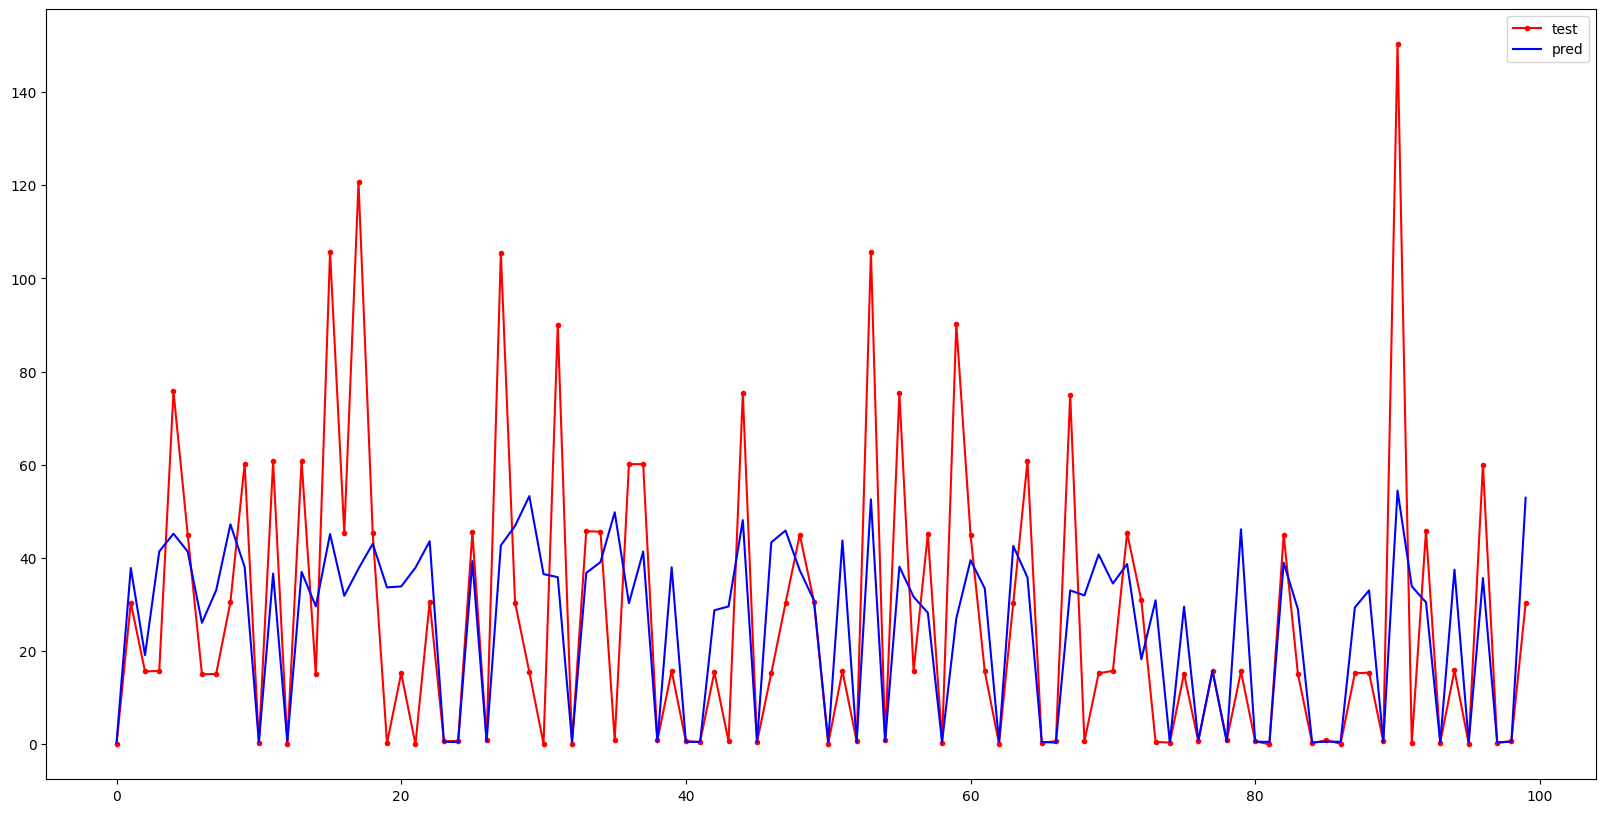

In [38]:
fig = plt.figure(figsize=(20, 10))

start = 300
end = 400

plt.plot(y_true[start:end], 'r.-', label='test')
plt.plot(preds[start:end], 'b-', label='pred')

plt.legend()

plt.show()

In [ ]:
y_std, y_mean

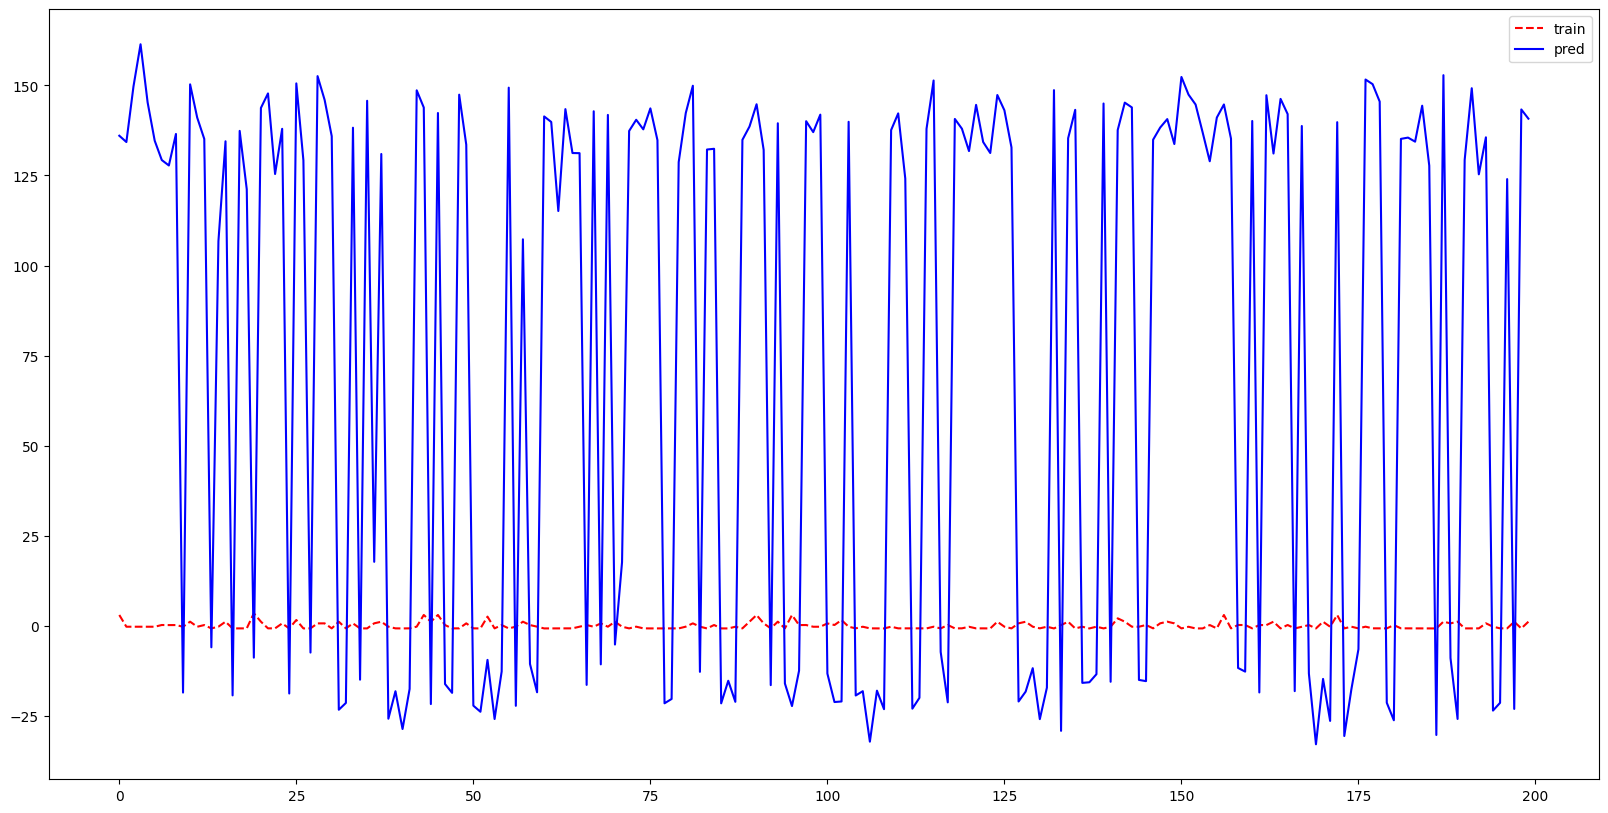

In [32]:
fig = plt.figure(figsize=(20, 10))

start = 400
end = 600

plt.plot(y_test[start:end], 'r--', label='train')
plt.plot(preds_train[start:end], 'b-', label='pred')

plt.legend()

plt.show()